## <span style="color:#956bbf">RFM: Recency, Frequency, Monetary value Summary</span>
---

### <span style="color:#956bbf">Introduction</span>
---

**Source**:
- [Creating an RFM Summary Using Excel](https://www.brucehardie.com/notes/022/)
- [Notes on the CDNOW Master Data Set](https://www.brucehardie.com/notes/026/)

In order to estimate the parameters of **transaction-flow models** such as the Pareto/NBD and BG/NBD, as well as those of the associated models for **spend per transaction** (spend model), we need an RFM (recency, frequency, monetary value) summary of each customer’s purchasing behavior. In particular,
1. The **transaction-flow model** requires three pieces of information about each customer’s purchasing history: their “recency”(when their last transaction occurred), “frequency” (how many transactions they made in a specified time period), and the length of time over which we have observed their purchasing behavior. The notation used to represent this information is $(x, tx, T)$, where $x$ is the number of transactions observed in the time period $(0, T]$ and $t_{x}$ $(0 \le tx \le T)$ is the time of the last transaction.
2. The **spend model** requires two pieces of information about each customer’s purchasing history: the average “monetary value” of each transaction (denoted by $m_x$) and the number of transactions over which this average is computed (i.e., frequency, $x$).

### <span style="color:#956bbf">Imports</span>
---

#### Import Packages

In [1]:
import polars as pl
import numpy as np

#### Import Data

We will make use of the CDNOW dataset. The master dataset contains the entire purchase history up to the end of June 1998 of the cohort of 23,570 individuals who made their first-ever purchase at CDNOW in the first quarter of 1997. 

The file `CDNOW_sample.csv` contains purchasing data for a 1/10th systematic sample of the whole cohort (2357 customers). Each record in this file, 6919 in total, comprises five fields: the customer’s ID in the master dataset, the customer’s ID in the 1/10th sample dataset (ranging from 1 to 2357), the date of the transaction, the number of CDs purchased, and the dollar value of the transaction.

In [2]:
CDNOW_master = (
    pl.scan_csv(source = 'data/CDNOW/CDNOW_master.csv', 
                has_header=False, 
                separator=',', 
                schema={'CustID': pl.Int32,     # customer id
                        'Date': pl.String,      # transaction date
                        'Quant': pl.Int16,      # number of CDs purchased
                        'Spend': pl.Float64})   # dollar value (excl. S&H)
    .with_columns(pl.col('Date').str.to_date("%Y%m%d"))
    .with_columns((pl.col('Date') - pl.date(1996,12,31)).dt.total_days().cast(pl.UInt16).alias('PurchDay'))
    .with_columns((pl.col('Spend')*100).round(0).cast(pl.Int64).alias('Spend Scaled'))
    .group_by('CustID', 'Date')
    .agg(pl.col('*').exclude('PurchDay').sum(), pl.col('PurchDay').max()) # Multiple transactions by a customer on a single day are aggregated into one
    .sort('CustID', 'Date')
    .with_columns((pl.col("CustID").cum_count().over("CustID") - 1).cast(pl.UInt16).alias("DoR"))  # DoR = Depth of Repeat ('Transaction' time: starts with 0 as trial, 1 as 1st repeat and so on)
)

In [3]:
# MATLAB Sampling (due to numerical float precision handling differences, original sampling results cannot be replicated unless spend is scaled in MATLAB)
CDNOW_sample = (
    pl.scan_csv(source='data/CDNOW/CDNOW_sample.csv',
                has_header=False,
                separator=',',
                schema={'CustID': pl.Int32,
                        'NewID': pl.Int32,
                        'Date': pl.String,
                        'Quant': pl.Int16,
                        'Spend': pl.Float64})
    .with_columns(pl.col('Date').str.to_date("%Y%m%d"))
    .with_columns((pl.col('Date') - pl.date(1996,12,31)).dt.total_days().cast(pl.UInt16).alias('PurchDay'))
    .with_columns((pl.col('Spend')*100).round(0).cast(pl.Int64).alias('Spend Scaled'))
    .group_by('NewID', 'Date')
    .agg(pl.col('*').exclude('PurchDay').sum(), pl.col('PurchDay').max())
    .sort('NewID', 'Date')
    .with_columns((pl.col("NewID").cum_count().over("NewID") - 1).cast(pl.UInt16).alias("DoR"))      
    .drop('CustID')
    .rename({'NewID': 'ID'})
)

1. We assume that the records in the raw transaction data file are grouped by customer, and sorted within customer by date of transaction. If in doubt, sort the raw dataset by customer ID and date of transaction.
2. As they are of no interest to us in this particular case, we delete the first and fourth columns (master dataset customer ID and # CDs purchased, respectively). 
3. We note that some customers had more than one transaction on a given day. For example, customer 26 had two separate transactions on 13 January 1997, while customer 46 had two separate transactions on 28 August 1997. There are about 233 such "additional" transactions. The transaction-flow models are developed by telling a story about **interpurchase times**. As we only know the date (and not the time) of each transaction, we need to aggregate the records associated with same-day transactions—we can’t have an interpurchase time of 0

### <span style="color:#956bbf">“Frequency” and “Monetary Value”</span>
---

We now compute the frequency and monetary value summaries for each customer.

Most of the previous analyses undertaken using this dataset have split the 78 weeks of data in half, creating a 39-week calibration period (1997-01-01 to 1997-09-30) and 39-week validation period (1997-10-01 to 1998-06-30). Furthermore, these analyses have generally ignored each customer’s first-ever purchase at CDNOW, which signals the start of the customer’s “relationship” with the firm; this means calibration-period “frequency” has usually been the number of repeat transactions, and “monetary value” has been the average dollar value per repeat transaction.

In [4]:
calwk = 273 # 39 week calibration period

CDNOW_sample = (
    CDNOW_sample
    .with_columns(
        pl.when(pl.col('DoR') == 0)
        .then(pl.lit('first'))
        .otherwise(pl.when(pl.col('PurchDay') <= calwk)
                   .then(pl.lit('calib'))
                   .otherwise(pl.lit('valid'))
        ).alias('Period')
    )
)

In [5]:
unauthorized_resellers = CDNOW_master.group_by('CustID').agg(pl.col('Spend').sum()).filter(pl.col('Spend') > 4200).collect()

CDNOW_master = (
    CDNOW_master
    .filter(~pl.col('CustID').is_in(unauthorized_resellers.select('CustID'))) # remove the purchasing data for ten buyers who purchased more than $4,000 worth of CDs across the 78-week period.
    .with_columns(
        pl.when(pl.col('DoR') == 0)
        .then(pl.lit('first'))
        .otherwise(pl.when(pl.col('PurchDay') <= calwk)
                   .then(pl.lit('calib'))
                   .otherwise(pl.lit('valid'))
        ).alias('Period')
    )
)

In [6]:
# the number of repeat transactions made in the calibration and validation periods
num_repeat_trans_sample = (
    CDNOW_sample
    .group_by('ID', 'Period')
    .agg(pl.len().alias('x'))
)

In [7]:
# the number of repeat transactions made in the calibration and validation periods
num_repeat_trans = (
    CDNOW_master
    .group_by('CustID', 'Period')
    .agg(pl.len().alias('x'))
)

In [8]:
# the average spend per repeat transaction for the calibration and validation periods
avg_spend_per_repeat_trans_sample = (
    CDNOW_sample
    .group_by('ID', 'Period')
    .agg(pl.col('Spend Scaled').mean().alias('m_x'))
)

In [9]:
# the average spend per repeat transaction for the calibration and validation periods
avg_spend_per_repeat_trans = (
    CDNOW_master
    .group_by('CustID', 'Period')
    .agg(pl.col('Spend Scaled').mean().alias('m_x'))
)

### <span style="color:#956bbf">“Recency”</span>
---

The next step is to compute recency, as well as the length of time over which we have observed each customer’s purchasing behavior.

$T$ is the effective calibration period, the length of time we observe each customer (i.e., the time between the customer’s first-ever purchase at CDNOW and the end of the calibration period)

In [10]:
# Effective calibration period - the length of time we observe each customer
eff_cal_period_sample = (
    CDNOW_sample
    .filter(pl.col('DoR') == 0)
    .with_columns(((pl.lit(calwk) - pl.col('PurchDay')) / 7).alias('T')) # Eff. Calibration Period
    .rename({'PurchDay': 'Trial Day'})   
)

In [11]:
# Effective calibration period - the length of time we observe each customer
eff_cal_period = (
    CDNOW_master
    .filter(pl.col('DoR') == 0)
    .with_columns(((pl.lit(calwk) - pl.col('PurchDay')) / 7).alias('T')) # Eff. Calibration Period
    .rename({'PurchDay': 'Trial Day'})   
)

For modeling purposes, “recency” is not the calendar date of the last observed purchase; rather the time origin for $t_x$ is the start of the observation period. Since we track customers’ purchasing from their first-ever purchase at CDNOW, the date of this first purchase is the time origin. Therefore, $t_x$ is the length of time between the first-ever purchase and the last observed purchase (in the calibration period), i.e., Last Purchase − First Purchase.

In [12]:
# time of last calibration period repeat purchase (in weeks) - recency number in days
ttlrp_sample = (
    CDNOW_sample
    .filter(pl.col('Period') != 'valid')
    .group_by('ID')
    .agg(pl.col('PurchDay').max())
    .join(other=eff_cal_period_sample, on='ID', how='left')
    .with_columns(((pl.col('PurchDay') - pl.col('Trial Day'))/7).alias('t_x')) # Time to Last Repeat
    .select('ID', 'T', 't_x')
)

ttlrp_sample.collect()

ID,T,t_x
i32,f64,f64
1,38.857143,30.428571
2,38.857143,1.714286
3,38.857143,0.0
4,38.857143,0.0
5,38.857143,0.0
…,…,…
2353,27.0,0.0
2354,27.0,24.285714
2355,27.0,0.0


In [13]:
# time of last calibration period repeat purchase (in weeks) - recency number in days
ttlrp = (
    CDNOW_master
    .filter(pl.col('Period') != 'valid')
    .group_by('CustID')
    .agg(pl.col('PurchDay').max())
    .join(other=eff_cal_period, on='CustID', how='left')
    .with_columns(((pl.col('PurchDay') - pl.col('Trial Day'))/7).alias('t_x')) # Time to Last Repeat
    .select('CustID', 'T', 't_x')
)

### <span style="color:#956bbf">RFM Summary</span>
---

RFM summary of calibration-period transactions:

This is the required “RFM” summary of calibration-period buying behavior needed to estimate the previously mentioned models of *transaction flow* and *spend per transaction*.

In [14]:
rfm_calib_sample = (
    CDNOW_sample
    .group_by('ID').agg()
    .join(
        other=num_repeat_trans_sample.filter(pl.col('Period') == 'calib').drop('Period'), 
        on='ID', how='left'
    ).join(
        other=avg_spend_per_repeat_trans_sample.filter(pl.col('Period') == 'calib').drop('Period'), 
        on='ID', how='left'
    ).join(
        other=ttlrp_sample, 
        on='ID', how='left'        
    ).fill_null(0)
)

In [15]:
rfm_calib = (
    CDNOW_master
    .group_by('CustID').agg()
    .join(
        other=num_repeat_trans.filter(pl.col('Period') == 'calib').drop('Period'), 
        on='CustID', how='left'
    ).join(
        other=avg_spend_per_repeat_trans.filter(pl.col('Period') == 'calib').drop('Period'), 
        on='CustID', how='left'
    ).join(
        other=ttlrp, 
        on='CustID', how='left'        
    ).fill_null(0)
)

In [16]:
total_valid_spend = (
    CDNOW_master
    .filter(pl.col('Period') == 'valid')
    .group_by("CustID")
    .agg(pl.col('Spend Scaled').sum().alias('Total Spend'))
)

total_valid_spend.collect()

CustID,Total Spend
i32,i64
3,9540
4,2648
5,12440
7,23593
8,9187
…,…
23556,5796
23558,4822
23561,5254


In [17]:
test = (
    rfm_calib
    .join(total_valid_spend, on='CustID', how='left')
    .with_columns(pl.col('x').cut(np.arange(0, 7), labels=[str(i) if i < 7 else '7+' for i in range(8)]))
    .with_columns(pl.col('t_x').cut(np.arange(0, 15), labels=[str(i) for i in range(16)]))
    .fill_null(0)
    .group_by('x', 't_x')
    .agg(pl.col('Total Spend').mean())
    .sort('Total Spend', descending=True)
    .collect()
    .sort('x')
    .pivot(on='x', index='t_x', values='Total Spend')
    .sort('t_x')
    .fill_null(0)
)
test

t_x,0,1,2,3,4,5,6,7+
cat,f64,f64,f64,f64,f64,f64,f64,f64
"""0""",913.390113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""1""",0.0,1479.390244,854.944444,7054.0,0.0,0.0,0.0,0.0
"""2""",0.0,1735.398281,1915.5,258.166667,14190.5,0.0,0.0,0.0
"""3""",0.0,1933.296667,1623.555556,8958.444444,0.0,0.0,0.0,0.0
"""4""",0.0,1855.200803,3345.527273,1093.529412,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…
"""11""",0.0,3308.375,4153.942029,4080.730769,14353.6,2318.2,499.5,0.0
"""12""",0.0,3394.594059,3383.54,4752.076923,6817.058824,1606.6,15241.0,24147.0
"""13""",0.0,4816.465347,3067.826923,4457.5,4066.0,3499.5,6877.6,0.0


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (40, 8) and arg 2 with shape (16, 8).

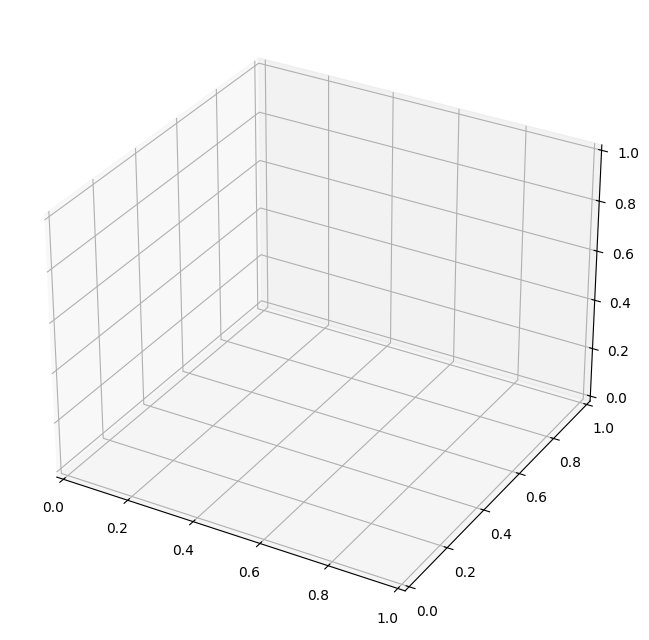

In [18]:
import matplotlib.pyplot as plt

X, Y = np.meshgrid(np.arange(8) + 1, np.arange(40) + 1)
Z = (test.to_numpy()[:,1:]/100)

fig, ax = plt.subplots(figsize=(8, 12), subplot_kw={'projection': '3d'})

# Give the first plot only wireframes of the type y = c
ax.plot_wireframe(X, Y, Z, rstride=0, cstride=7)
ax.set_title(" Average Total Spend in Weeks 40–78 by Recency and Frequency in Weeks 1–39")

ax.view_init(elev=30, azim=-140, roll=0)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.tight_layout()
plt.show()

We can create a summary of validation-period purchasing behavior by extracting the corresponding
number of transactions and average spend per transaction numbers from the dataframes constructed above.

#### The number of repeat transactions made by each customer in each period

In [ ]:
calwk = 273 # 39 week calibration period

# The number of repeat transactions made by each customer in each period
px = (
    CDNOW_sample
    .group_by('ID', maintain_order=True)
    .agg(
        pl.col('PurchDay')
        .filter((pl.col('PurchDay') <= calwk) & (pl.col('DoR') > 0))
        .count()
        .alias('P1X'), # Period 1: Calibration Period

        pl.col('PurchDay')
        .filter((pl.col('PurchDay') > calwk) & (pl.col('DoR') > 0))
        .count()
        .alias('P2X')  # Period 2: Longitudinal Holdout Period      
    )
)

#### The number of CDs purchased and total spend across these repeat transactions

In [ ]:
# The number of CDs purchased and total spend across these repeat transactions
pSpendQuant = (
    CDNOW_sample
    .join(px, on='ID', how='left')
    .group_by('ID', maintain_order=True)
    .agg(
        
        pl.col('Spend Scaled')
        .filter((pl.col('DoR') > 0) & (pl.col('DoR') <= pl.col('P1X')) & (pl.col('P1X') != 0))
        .sum()
        .alias('P1X Spend'),
        
        pl.col('Quant')
        .filter((pl.col('DoR') > 0) & (pl.col('DoR') <= pl.col('P1X')) & (pl.col('P1X') != 0))
        .sum()
        .alias('P1X Quant'),        
        
        pl.col('Spend Scaled')
        .filter((pl.col('DoR') > 0) & (pl.col('DoR') > pl.col('P1X')))
        .sum()
        .alias('P2X Spend'),
        
        pl.col('Quant')
        .filter((pl.col('DoR') > 0) & (pl.col('DoR') > pl.col('P1X')))
        .sum()
        .alias('P2X Quant')                
    )
)

#### The average spend per repeat transaction

In [ ]:
# The average spend per repeat transaction
mx = (
    pSpendQuant
    .join(px, on='ID', how='left')
    .with_columns(
        (pl.col('P1X Spend') / pl.col('P1X')).alias('Avg Spend per Repeat')
    ).fill_nan(0)
)

#### Recency & effective calibration period

When fitting models such as the Pareto/NBD and BG/NBD to these data, we also want to know the “recency” information for each customer, as well as their effective calibration period:

In [ ]:
# time of last calibration period repeat purchase (in weeks)
ttlrp = (
    CDNOW_sample
    .join(px, on='ID', how='left')
    .with_columns(
        pl.col('PurchDay').filter(pl.col('DoR') == 0)
        .first()
        .over('ID')
        .alias('Trial Day')
    )
    .group_by('ID', maintain_order=True)
    .agg(
        pl.col('PurchDay', 'Trial Day')
        .filter(pl.col('DoR') <= pl.col('P1X'))
        .max()
        # .alias('LastPurch')
    )
    .with_columns(
        # effective calibration period (in weeks)
        ((pl.col('PurchDay') - pl.col('Trial Day')) / 7).alias('Time to Last Repeat'),
        ((calwk - pl.col('Trial Day'))/7).alias('Eff. Calibration Period')
    )
    .drop('PurchDay', 'Trial Day')
)